<a href="https://colab.research.google.com/github/vitalns/test/blob/main/pairplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
<h2> <font color='blue'>Построение парной диаграммы </font> </h2>
</div>

Примеры посторения парной диаграммы с использованием pairplot и pairgrid. На графики добавлены маркеры средних значений, анотации, легенда, ...

#*Построение парной диаграммы*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## *Предобработка данных*

In [ ]:
# Загрузим датасет "Пингвины"

penguins = sns.load_dataset("penguins")
penguins.dropna(inplace=True)
penguins.reset_index(drop=True, inplace=True)

In [ ]:
# Создадим таблицу со средними значениями.

species = penguins.species.unique()
averages = [penguins[penguins['species']==i].mean().to_list() for i in species]
avg_data = pd.DataFrame(averages, columns=penguins.select_dtypes(np.number).columns)
avg_data['species'] = species
avg_data

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,38.823973,18.347260,190.102740,3706.164384,Adelie
1,48.833824,18.420588,195.823529,3733.088235,Chinstrap
2,47.568067,14.996639,217.235294,5092.436975,Gentoo


In [ ]:
# Добавим средние значения характеристик к общей таблице.

avg = avg_data.copy(deep=True)
avg.species = 'mean' # Добавляем заглушку для hue в pairgrid.
data_all = pd.concat([penguins, avg], ignore_index=True)
data_all.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
331,Gentoo,Biscoe,45.200000,14.800000,212.000000,5200.000000,Female
332,Gentoo,Biscoe,49.900000,16.100000,213.000000,5400.000000,Male
333,mean,NaN,38.823973,18.347260,190.102740,3706.164384,NaN
334,mean,NaN,48.833824,18.420588,195.823529,3733.088235,NaN
335,mean,NaN,47.568067,14.996639,217.235294,5092.436975,NaN


##*Построение парной диаграммы с помощью* ***pairplot***.

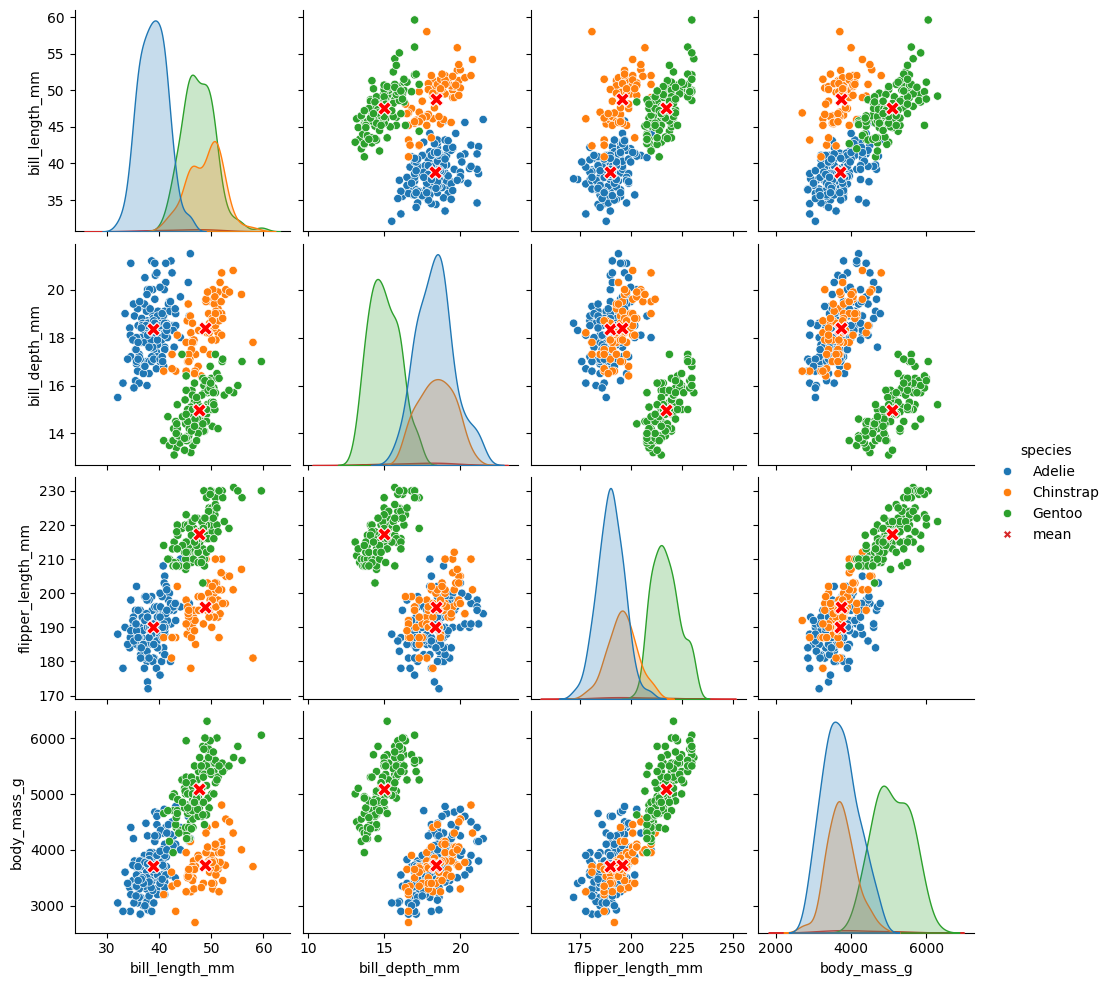

In [ ]:
# Построим парную диаграмму с помощью pairplot и добавим средние значения на график.

pairgrid = sns.pairplot(data=data_all,
                        hue='species',
                        #diag_kind='kde',  # по умолчанию
                        markers=['o', 'o', 'o', 'X'],
                        #palette='tab10',  # по умолчанию
                        )

# С помощью pairgrid можно отдельно настроить размер, цвет и тип маркера среднего "X"
# (для управления цветом нужно задать hue=None).

pairgrid.data = avg
pairgrid.map_offdiag(func=sns.scatterplot, s=100, marker='X', hue=None, color='r')

# В легенде по умолчанию используется список созданных экземпляров из hue.
# pairgrid.add_legend(legend_data=pairgrid._legend_data).
# Так как pairgrid.data не добавляет новые данные в hue, цвет и размер маркера среднего "Х" на легенде не меняется.
# pairgrid._legend.remove()  # Убрать легенду можно используя метод remove.

##*Построение парной диаграммы с помощью* ***pairgrid***.

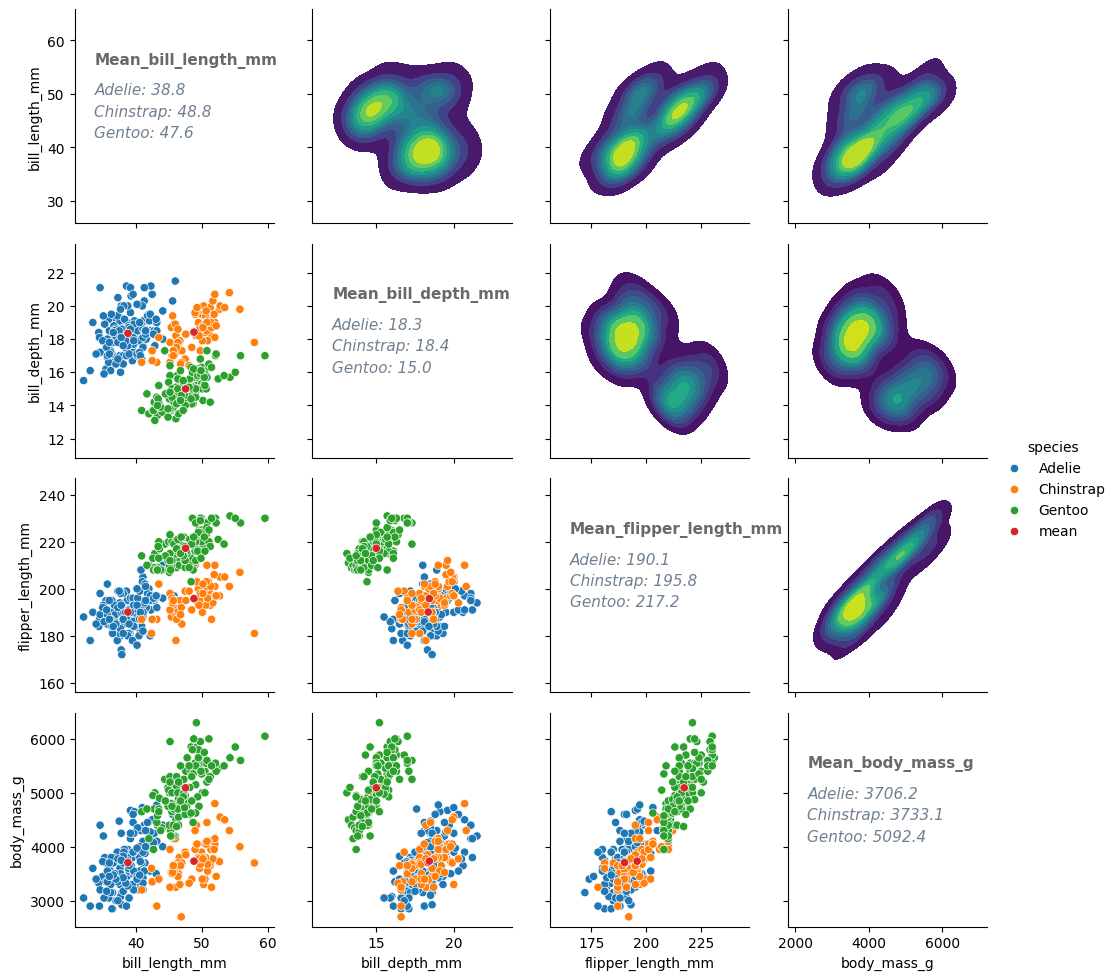

In [ ]:
# Построим парную диаграмму с помощью pairgrid и добавим анотацию на диагональные графики.

# Создадим объект класса PairGrid.
g = sns.PairGrid(data_all,  # Полный датасет с добавленным средними значениями (species="mean")
                 hue='species',
                 palette='tab10'
                 )
# На нижних графиках построим диаграммы рассеяния, а на верхних диаграмму "плотности"
g.map_lower(sns.scatterplot)  # Функию можно задать plt.scatter, но у seaborn больше настроек.
g.map_upper(sns.kdeplot,
            hue=None,
            cmap='viridis',
            fill=True
            )
g.add_legend()

# Добавим на диагональные элементы средние значения текстом.

def annotate_func(*args, **kwargs):
  mean = args[0].mean()
  ax = plt.gca()
  # Каждое значения species из списка hue нужно записать с новой строки,
  # поэтому будем считать сколько экземпляров дочернего класса matplotlib.text.Annotation уже есть.
  # Можно считать экземпляры matplotlib.text.Text, но так как на графике уже есть подписи, то начальное значение не нулевое.
  n = len([c for c in ax.get_children() if isinstance(c, matplotlib.text.Annotation)])
  pos = (.1, .6 - .1*n)
  if n == 0:  # Добавим заглавие фичи для которой вычесляем среднее
    ax.text(.1,.8,
            f"Mean_{args[0].name}",
            size=11, weight='black', stretch='condensed', color='dimgray',
            va='top',  # По умолчанию ha='left' и va='bottom'
            transform=ax.transAxes
            )
  if kwargs['label'] in g._hue_order[:3]:  # Добавим среднее для всех species из фрейма, кроме mean.
    ax.annotate(f"{kwargs['label']}: {mean:.1f}",
                size=11, style='oblique', c='slategray',
                xy=pos, xycoords=ax.transAxes
                )
g.map_diag(annotate_func)

---

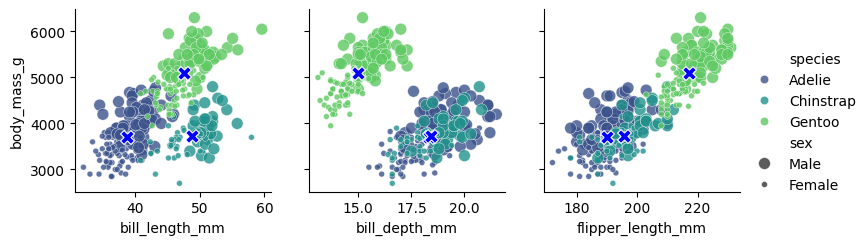

In [ ]:
# Ещё пример построения парной диаграммы с pairgrid.

x_vars = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
y_vars = ['body_mass_g']
g = sns.PairGrid(penguins,
                 hue='species',
                 x_vars=x_vars,
                 y_vars=y_vars,
                 palette='viridis'
                 )
g.map_offdiag(sns.scatterplot,
              size=penguins.sex,
              alpha=0.8
              )

# Добавляем средние значения
avg = avg_data.copy(deep=True)
avg.species = 'mean'
g.data = avg
g.map_offdiag(func=sns.scatterplot, s=100, marker='X', hue=None, c='b')

g.add_legend(title='',
             adjust_subtitles=True  # Выравнивает текст на легенде
             )
#  На легенде отсутствует маркер среднего, так как список экземпляров для легенды берётся из hue,
#  а средние значения добавлены 'сверху'.

# def annotate_func(*args, **kwargs):
#   max_x = args[0].max()
#   max_y = args[1].max()
#   ax = plt.gca()
#   print(max_x, max_y)
#   # print(ax.get_ylim)
#   n = len([c for c in ax.get_children() if isinstance(c, matplotlib.text.Annotation)])
#   pos = (.1, .6 - .1*n)
#   if kwargs['label'] in g._hue_order[:3]:
#     ax.annotate(f"{kwargs['label']}: {max_x:.1f}",
#                 size=7, style='oblique', c='navy', weight='semibold',
#                 xy=pos, xycoords=ax.transAxes
#                 )
#   # ax.annotate(f"{kwargs['label'][0]}",
#   #               size=7, style='oblique', c='navy', weight='semibold',
#   #               xy=(.2,.5),
#   #               # xy=(avg_data[avg_data.species == 'Adelie'][x_vars[0]]/max_x, avg_data[avg_data.species == 'Adelie'][y_vars[0]]/max_y),
#   #               xycoords=ax.transAxes
#   #               )
#   ax.annotate(f"{kwargs['label']}: {max_x:.1f}",
#                 size=7, style='oblique', c='navy', weight='semibold',
#                 xy=pos, xycoords=ax.transAxes
#                 )
# g.map_offdiag(annotate_func)